In [1]:
#https://ithelp.ithome.com.tw/articles/10195071
#https://github.com/GeneralMills/pytrends
import pandas as pd
import numpy as np
import datetime as dt
import psycopg2
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time

#set chinese font
from matplotlib.font_manager import FontProperties
sn.set(font=['sans-serif'])
sn.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})

pd.set_option('display.max_columns', 100)
pd.options.display.max_rows = 999

import sys
sys.path.append("..")
from _module_.dbtool import io

import warnings
warnings.filterwarnings("ignore")

from pytrends.request import TrendReq
pytrend = TrendReq()

In [2]:
# LSTM for international airline passengers problem with regression framing
import math
from keras.models import Sequential, Model
from keras.layers import Dense, TimeDistributed, Activation, Dropout, Flatten, LSTM, LeakyReLU, Lambda, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
#relevant = ['神腦', '中華電信']

In [4]:
def gtrend2(key_array, first='2017-01-01', last='2017-02-01', plot=True):
    start = [int(i) for i in first.split('-')]
    end = [int(i) for i in last.split('-')]
    
    cnt = 0
    for key in key_array:
        print("Obtaining {}...\n".format(key))
        tmp = pytrend.get_historical_interest([key], year_start=start[0], month_start=start[1], day_start=start[2], 
                                              hour_start=0, year_end=end[0], month_end=end[1], day_end=end[2], hour_end=23, 
                                              cat=0, geo='', gprop='', sleep=3.5)
        tmp = tmp.reset_index()
        
        if cnt==0:
            ans = tmp
            if cnt!=0:
                time.sleep(2)
        else:
            ans = ans.merge(tmp, on='date', how='left')
        cnt += 1
        time.sleep(3)
    
    ans[key_array] = ans[key_array].astype('int')
    ans['date'] = pd.to_datetime(ans['date'])
    ans = ans[['date']+key_array]
    

    if plot:
        scale = MinMaxScaler()
        tmp2 = ans.copy(deep=True)
        tmp2[key_array] = pd.DataFrame(scale.fit_transform(tmp2[key_array]), columns=key_array) 
        
        plt.subplots(figsize=(10,6))
        for key in key_array:
            sn.lineplot(y = key, x = "date", data = tmp2, linewidth = 3, label=key)
        plt.xticks(rotation=45); plt.ylabel('Trend'); plt.xlabel('Time')
    
    return(ans)

In [5]:
relevant = ['神腦', '中華電信', '遠傳', '台哥大', 'friDay', #相關通訊產業 
            '博客來','pchome','momo', '燦坤', '全國電子',  #網購
            'iphone','apple','手機','家電', 'iphone 維修', '電信方案', 'samsung', 'ZenPhone', '換電池', '手機維修', '手機保險',  #相關商品
            '中華電信續約', '保護貼', '手機包膜', '舊機回收', 
            '製造業', '鴻海股價', '大立光', '網購', #經濟狀況
            '神腦維修',#'神腦換電池','神腦預約','神腦股價', #神腦相關
            '比價王', 'FindPrice', '手機王', 'ePrice' #比架網佔
            ]

In [ ]:
result = []
for re in relevant[:2]:
    print("Processing {}...".format(re))
    result.append(gtrend2([re], first='2019-01-01', last='2019-04-01', plot=False))
    time.sleep(10)
print("ALL PROCESS DONE!!!")

In [ ]:
ltest = [len(i) for i in result]
same_len = all([i==ltest[0] for i in ltest])

if same_len:
    data = result[0]
    for d in result[1:]:
        data = pd.concat([data, d.iloc[:,1]],1)
    print("Cancatenation Done!!")
else:
    print("Different Lengths!!")

In [ ]:
data.to_csv('./hourly_trend', index=False)

In [6]:
def time_grouper(df, fr='W-SUN', gkey='week', aggkey=['norder'], aggfunc='sum'):
    dfout = df.copy(deep=True)
    if fr[0]=='D' or fr[0]=='H':
        dfout = dfout.groupby([pd.Grouper(key=gkey, freq=fr)]).agg({k:aggfunc for k in aggkey}).reset_index().sort_values(gkey)
    elif fr[0]=='W':
        dfout[gkey] = pd.to_datetime(dfout[gkey]) - pd.to_timedelta(7, unit='d')
        dfout = dfout.groupby([pd.Grouper(key=gkey, freq=fr)]).agg({k:aggfunc for k in aggkey}).reset_index().sort_values(gkey)
    else:
        print("Frequency Type Currently Not Supported!!")
        return(None)
    
    return(dfout)

def trend_merge(df1,df2, on1='week', on2='week'):
    #df1 is dominant [weeek trend]
    #df2 [week year weeknum norder (week_new) (weekday)]
    d1 = df1.copy(deep=True)
    d2 = df2.copy(deep=True)
    d1['week_new'] = pd.to_datetime(d1[on1])
    d2['week_new'] = pd.to_datetime(d2[on2])
    
    return(d1[['week_new','trend']].merge(d2[['week_new','norder', 'amt']], on='week_new', how='left'))

In [7]:
#"線上訂單"
d4 = io.read_table('felixlin."Proj003_google_trend_all_online_hour"', 'std')
d4 = time_grouper(d4, fr='H',aggkey=['norder','amt'])
data = pd.read_csv('./hourly_trend')
data['date'] = pd.to_datetime(data['date'])
d5 = io.read_table('felixlin."Proj003_google_trend_track_hour"', 'std')
d5 = time_grouper(d5, fr='H',aggkey=['mmb'])

Connection Established.
Connection Established.


In [8]:
d4_ = time_grouper(d4, fr='D',aggkey=['norder','amt'], aggfunc='sum')
data_ = time_grouper(data, fr='D', gkey='date', aggkey=data.columns[1:].tolist(), aggfunc='mean')
d5_ = time_grouper(d5, fr='D',aggkey=['mmb'], aggfunc='sum')

In [9]:
d5_.head()

,week,mmb
0,2019-01-01,10691
1,2019-01-02,12258
2,2019-01-03,12585
3,2019-01-04,12879
4,2019-01-05,7450


In [10]:
test1 = data.merge(d4, left_on='date', right_on='week', how='left').merge(d5, left_on='date', right_on='week', how='left')
test1.drop(['week_x', 'week_y', 'amt'],axis=1,inplace=True)
test1.head(1)
test2 = data_.merge(d4_, left_on='date', right_on='week', how='left').merge(d5_, left_on='date', right_on='week', how='left')
test2.drop(['week_x', 'week_y', 'amt'],axis=1,inplace=True)
test2.head(1)

,date,神腦,中華電信,遠傳,台哥大,friDay,博客來,pchome,momo,燦坤,全國電子,iphone,apple,手機,家電,iphone 維修,電信方案,samsung,ZenPhone,換電池,手機維修,手機保險,中華電信續約,保護貼,手機包膜,舊機回收,製造業,鴻海股價,大立光,網購,神腦維修,比價王,FindPrice,手機王,ePrice,norder,mmb
0,2019-01-01,3.75,3.25,4.958333,4.75,13.375,5.375,6.958333,29.125,2.125,3.125,34.625,29.0,8.541667,7.541667,5.75,4.125,31.291667,15.875,5.916667,3.125,3.125,2.125,6.5,3.0,3.958333,2.833333,0.25,0.875,7.625,0.833333,6.75,4.666667,6.416667,21.125,315,10691


In [11]:
test1.rename(columns={'神腦':'神腦g','norder':'神腦'},inplace=True)
test2.rename(columns={'神腦':'神腦g','norder':'神腦'},inplace=True)
#test2.set_index('date',inplace=True)

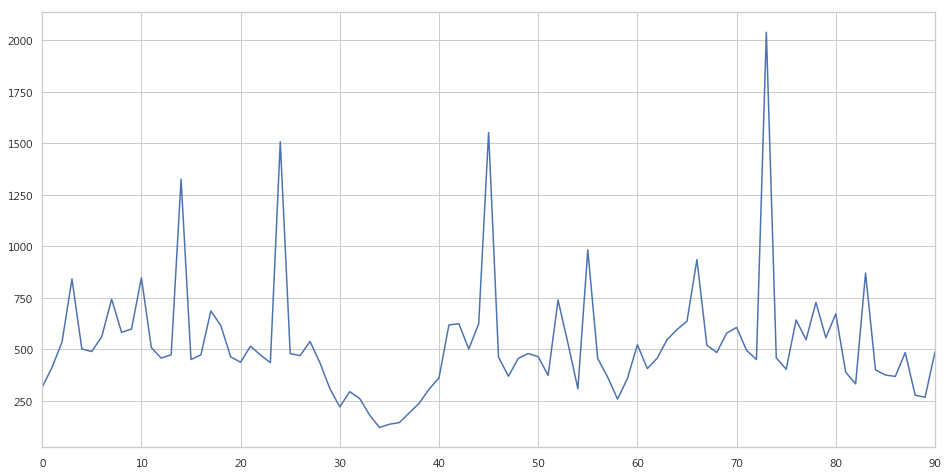

In [12]:
plt.figure(figsize=(16,8))
test2['神腦'].plot()

In [ ]:
plt.figure(figsize=(16,8))
pd.plotting.autocorrelation_plot(d4_.norder)

In [ ]:
test1[['神腦','mmb']].corr('spearman')

In [13]:
def time_shift(data, dic):
    dat = data.copy(False)
    for key in dic.keys():
        dat[key] = dat[key].shift(dic[key])
    dat = dat.dropna()
    return(dat)

def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

def build_train(train, ylab=['神腦'], past=1, future=1):
    X_train, Y_train = [], []
    for i in range(past, train.shape[0]-future):  
        if ylab is None:
            X_train.append(np.array(train.iloc[i-past:i]))
            Y_train = None
        else:
            X_train.append(np.array(train.iloc[i-past:i].drop(ylab,axis=1)))
            if future>1:
                Y_train.append(np.array(train.iloc[i:i+future][ylab]))
            else:
                Y_train.append(np.array(train.iloc[i][ylab]))
    X_train = np.array(X_train)
    if ylab is not None:
        Y_train = np.array(Y_train)
    
    return(X_train, Y_train)

def train_test_split(X,Y,rate=0.7):
    X_train = X[:int(X.shape[0]*rate)]
    Y_train = Y[:int(Y.shape[0]*rate)]
    X_val = X[int(X.shape[0]*rate):]
    Y_val = Y[int(Y.shape[0]*rate):]
    return(X_train, Y_train, X_val, Y_val)

def train_plot(Ytrain, Yval, trainPredict, testPredict):
    Ytruth = np.concatenate([Ytrain.reshape(Ytrain.shape[0],),Yval.reshape(Yval.shape[0],)])
    trainPredictPlot = np.empty_like(Ytruth)
    testPredictPlot = np.empty_like(Ytruth)
    testPredictPlot[:] = np.nan 
    trainPredictPlot[:] = np.nan
    
    trainPredictFlat = trainPredict.reshape(trainPredict.shape[0],)
    testPredictFlat = testPredict.reshape(testPredict.shape[0],)
    trainPredictPlot[:trainPredictFlat.shape[0]] = trainPredictFlat
    testPredictPlot[trainPredictFlat.shape[0]:] = testPredictFlat
    
    plt.figure(figsize=(10,6))
    plt.plot(Ytruth,linewidth = 2.5, label='Truth')
    plt.plot(trainPredictPlot,linewidth = 2.5, label='Train Prediction',color='red')
    plt.plot(testPredictPlot,linewidth = 2.5, label='Test Prediction',color='yellow')
    plt.legend(loc='upper right')
    
def conclude(model,Xtrain,Xval,Ytrain,Yval):
    trainPredict = model.predict(Xtrain)
    testPredict = model.predict(Xval)
    trainY = Ytrain
    testY = Yval

    # calculate 均方根誤差(root mean squared error)
    trainScore = math.sqrt(mean_squared_error(trainY.reshape(trainY.shape[0],), trainPredict.reshape(trainPredict.shape[0],)))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY.reshape(testY.shape[0],), testPredict.reshape(testPredict.shape[0],)))
    print('Test Score: %.2f RMSE' % (testScore))
    train_plot(Ytrain, Yval, trainPredict, testPredict)

In [140]:
interest = relevant+['神腦g']#,'mmb']#['神腦','中華電信','iphone','博客來','電信方案','ZenPhone','samsung','手機','家電']
r2_ = test2.copy(deep=True).drop('date',1)
dic = {'神腦':0}#,'mmb':0}
dat = time_shift(r2_,dic)
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
#scaler3 = StandardScaler()
dat= pd.concat([pd.DataFrame(scaler1.fit_transform(dat['神腦'].values.reshape(-1, 1)),columns=['神腦']),
                pd.DataFrame(scaler2.fit_transform(dat[interest[1:]]), columns=interest[1:])], axis=1)

# # Best Senerio

In [ ]:
# Best Senerio
def model_lstm(shape, n_neurons=100,den=1):
    model = Sequential()
    #https://github.com/MorvanZhou/tutorials/issues/30
    model.add(LSTM(n_neurons, input_shape=(shape[1],shape[2]), return_sequences=False))
    #model.add(TimeDistributed(Dense(10,activation='linear')))
    #model.add(LSTM(output_dim=nfuture, return_sequences=True))
    #model.add(LSTM(20,return_sequences=False))
    #model.add(LSTM(20,return_sequences=False))
    #model.add(Dropout(0.05))
    #model.add(BatchNormalization())
    model.add(Dense(10, activation='linear'))
    model.add(Dropout(0.05))
    #model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(5,activation='linear'))
    model.add(Dropout(0.05))
    model.add(Dense(1,activation='linear'))
    #model.add(TimeDistributed(Dense(1,activation='linear')))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return(model)

In [ ]:
# Best Senerio
X_train, Y_train = build_train(dat,ylab=['神腦'], past=4, future=1)
Xtrain, Ytrain, Xval, Yval = train_test_split(X_train, Y_train, rate=0.7)

model = model_lstm(Xtrain.shape,100, den=1)
callback = EarlyStopping(monitor="val_loss", patience=20, verbose=1, mode="auto")
model.fit(Xtrain, Ytrain, epochs=100, batch_size = 10, validation_data=(Xval, Yval), callbacks=[callback])
conclude(model,Xtrain,Xval,Ytrain,Yval)

In [ ]:
testPredict = model.predict(Xval)
timestamp = np.array(test2[-Xval.shape[0]:]['date'].dt.date)
ind = np.arange(Xval.shape[0])
pnt = 7

plt.subplots(dpi=500)
plt.plot(scaler1.inverse_transform(Yval),label='真實')
plt.plot(scaler1.inverse_transform(testPredict),label='預測')
plt.xticks([i for i in ind if i%pnt==0],[timestamp[i] for i in ind if i%pnt==0],rotation=0)
plt.legend()
plt.tight_layout()

# Testing senerio with member views

In [174]:
# Testing Senerio with member views
def model_lstm(shape, n_neurons=100,den=1):
    model = Sequential()
    #https://github.com/MorvanZhou/tutorials/issues/30
    model.add(LSTM(n_neurons, input_shape=(shape[1],shape[2]), return_sequences=False))
    #model.add(TimeDistributed(Dense(10,activation='linear')))
    #model.add(LSTM(output_dim=nfuture, return_sequences=True))
    #model.add(LSTM(20,return_sequences=False))
    #model.add(LSTM(20,return_sequences=False))
    #model.add(Dropout(0.05))
    #model.add(BatchNormalization())
    model.add(Dense(10, activation='linear'))
    model.add(Dropout(0.05))
    #model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(5,activation='linear'))
    model.add(Dropout(0.05))
    model.add(Dense(1,activation='linear'))
    #model.add(TimeDistributed(Dense(1,activation='linear')))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100)               54000     
_________________________________________________________________
dense_85 (Dense)             (None, 10)                1010      
_________________________________________________________________
dropout_47 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 5)                 55        
_________________________________________________________________
dropout_48 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 6         
Total params: 55,071
Trainable params: 55,071
Non-trainable params: 0
_________________________________________________________________
Train 

Epoch 70/250
60/60 [==============================] - 0s 432us/step - loss: 0.0131 - val_loss: 0.0268
Epoch 71/250
60/60 [==============================] - 0s 532us/step - loss: 0.0136 - val_loss: 0.0248
Epoch 72/250
60/60 [==============================] - 0s 565us/step - loss: 0.0114 - val_loss: 0.0255
Epoch 73/250
60/60 [==============================] - 0s 548us/step - loss: 0.0097 - val_loss: 0.0256
Epoch 74/250
60/60 [==============================] - 0s 515us/step - loss: 0.0117 - val_loss: 0.0252
Epoch 75/250
60/60 [==============================] - 0s 465us/step - loss: 0.0107 - val_loss: 0.0276
Epoch 76/250
60/60 [==============================] - 0s 515us/step - loss: 0.0096 - val_loss: 0.0251
Epoch 77/250
60/60 [==============================] - 0s 515us/step - loss: 0.0098 - val_loss: 0.0247
Epoch 78/250
60/60 [==============================] - 0s 515us/step - loss: 0.0121 - val_loss: 0.0255
Epoch 79/250
60/60 [==============================] - 0s 515us/step - loss: 0.0171

Epoch 150/250
60/60 [==============================] - 0s 465us/step - loss: 0.0070 - val_loss: 0.0235
Epoch 151/250
60/60 [==============================] - 0s 449us/step - loss: 0.0049 - val_loss: 0.0242
Epoch 152/250
60/60 [==============================] - 0s 416us/step - loss: 0.0076 - val_loss: 0.0253
Epoch 153/250
60/60 [==============================] - 0s 432us/step - loss: 0.0082 - val_loss: 0.0236
Epoch 154/250
60/60 [==============================] - 0s 416us/step - loss: 0.0074 - val_loss: 0.0201
Epoch 155/250
60/60 [==============================] - 0s 532us/step - loss: 0.0074 - val_loss: 0.0243
Epoch 156/250
60/60 [==============================] - 0s 515us/step - loss: 0.0063 - val_loss: 0.0203
Epoch 157/250
60/60 [==============================] - 0s 532us/step - loss: 0.0077 - val_loss: 0.0264
Epoch 158/250
60/60 [==============================] - 0s 532us/step - loss: 0.0060 - val_loss: 0.0201
Epoch 159/250
60/60 [==============================] - 0s 532us/step - lo

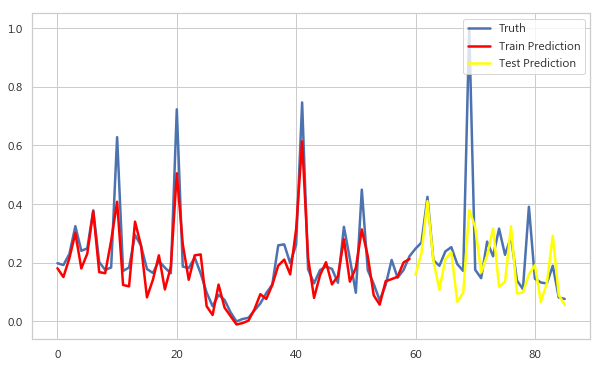

In [175]:
X_train, Y_train = build_train(dat,ylab=['神腦'], past=4, future=1)
Xtrain, Ytrain, Xval, Yval = train_test_split(X_train, Y_train, rate=0.7)

model = model_lstm(Xtrain.shape,100, den=1)
callback = EarlyStopping(monitor="val_loss", patience=20, verbose=1, mode="auto")
model.fit(Xtrain, Ytrain, epochs=250, batch_size = 24, validation_data=(Xval, Yval), callbacks=[callback])
conclude(model,Xtrain,Xval,Ytrain,Yval)

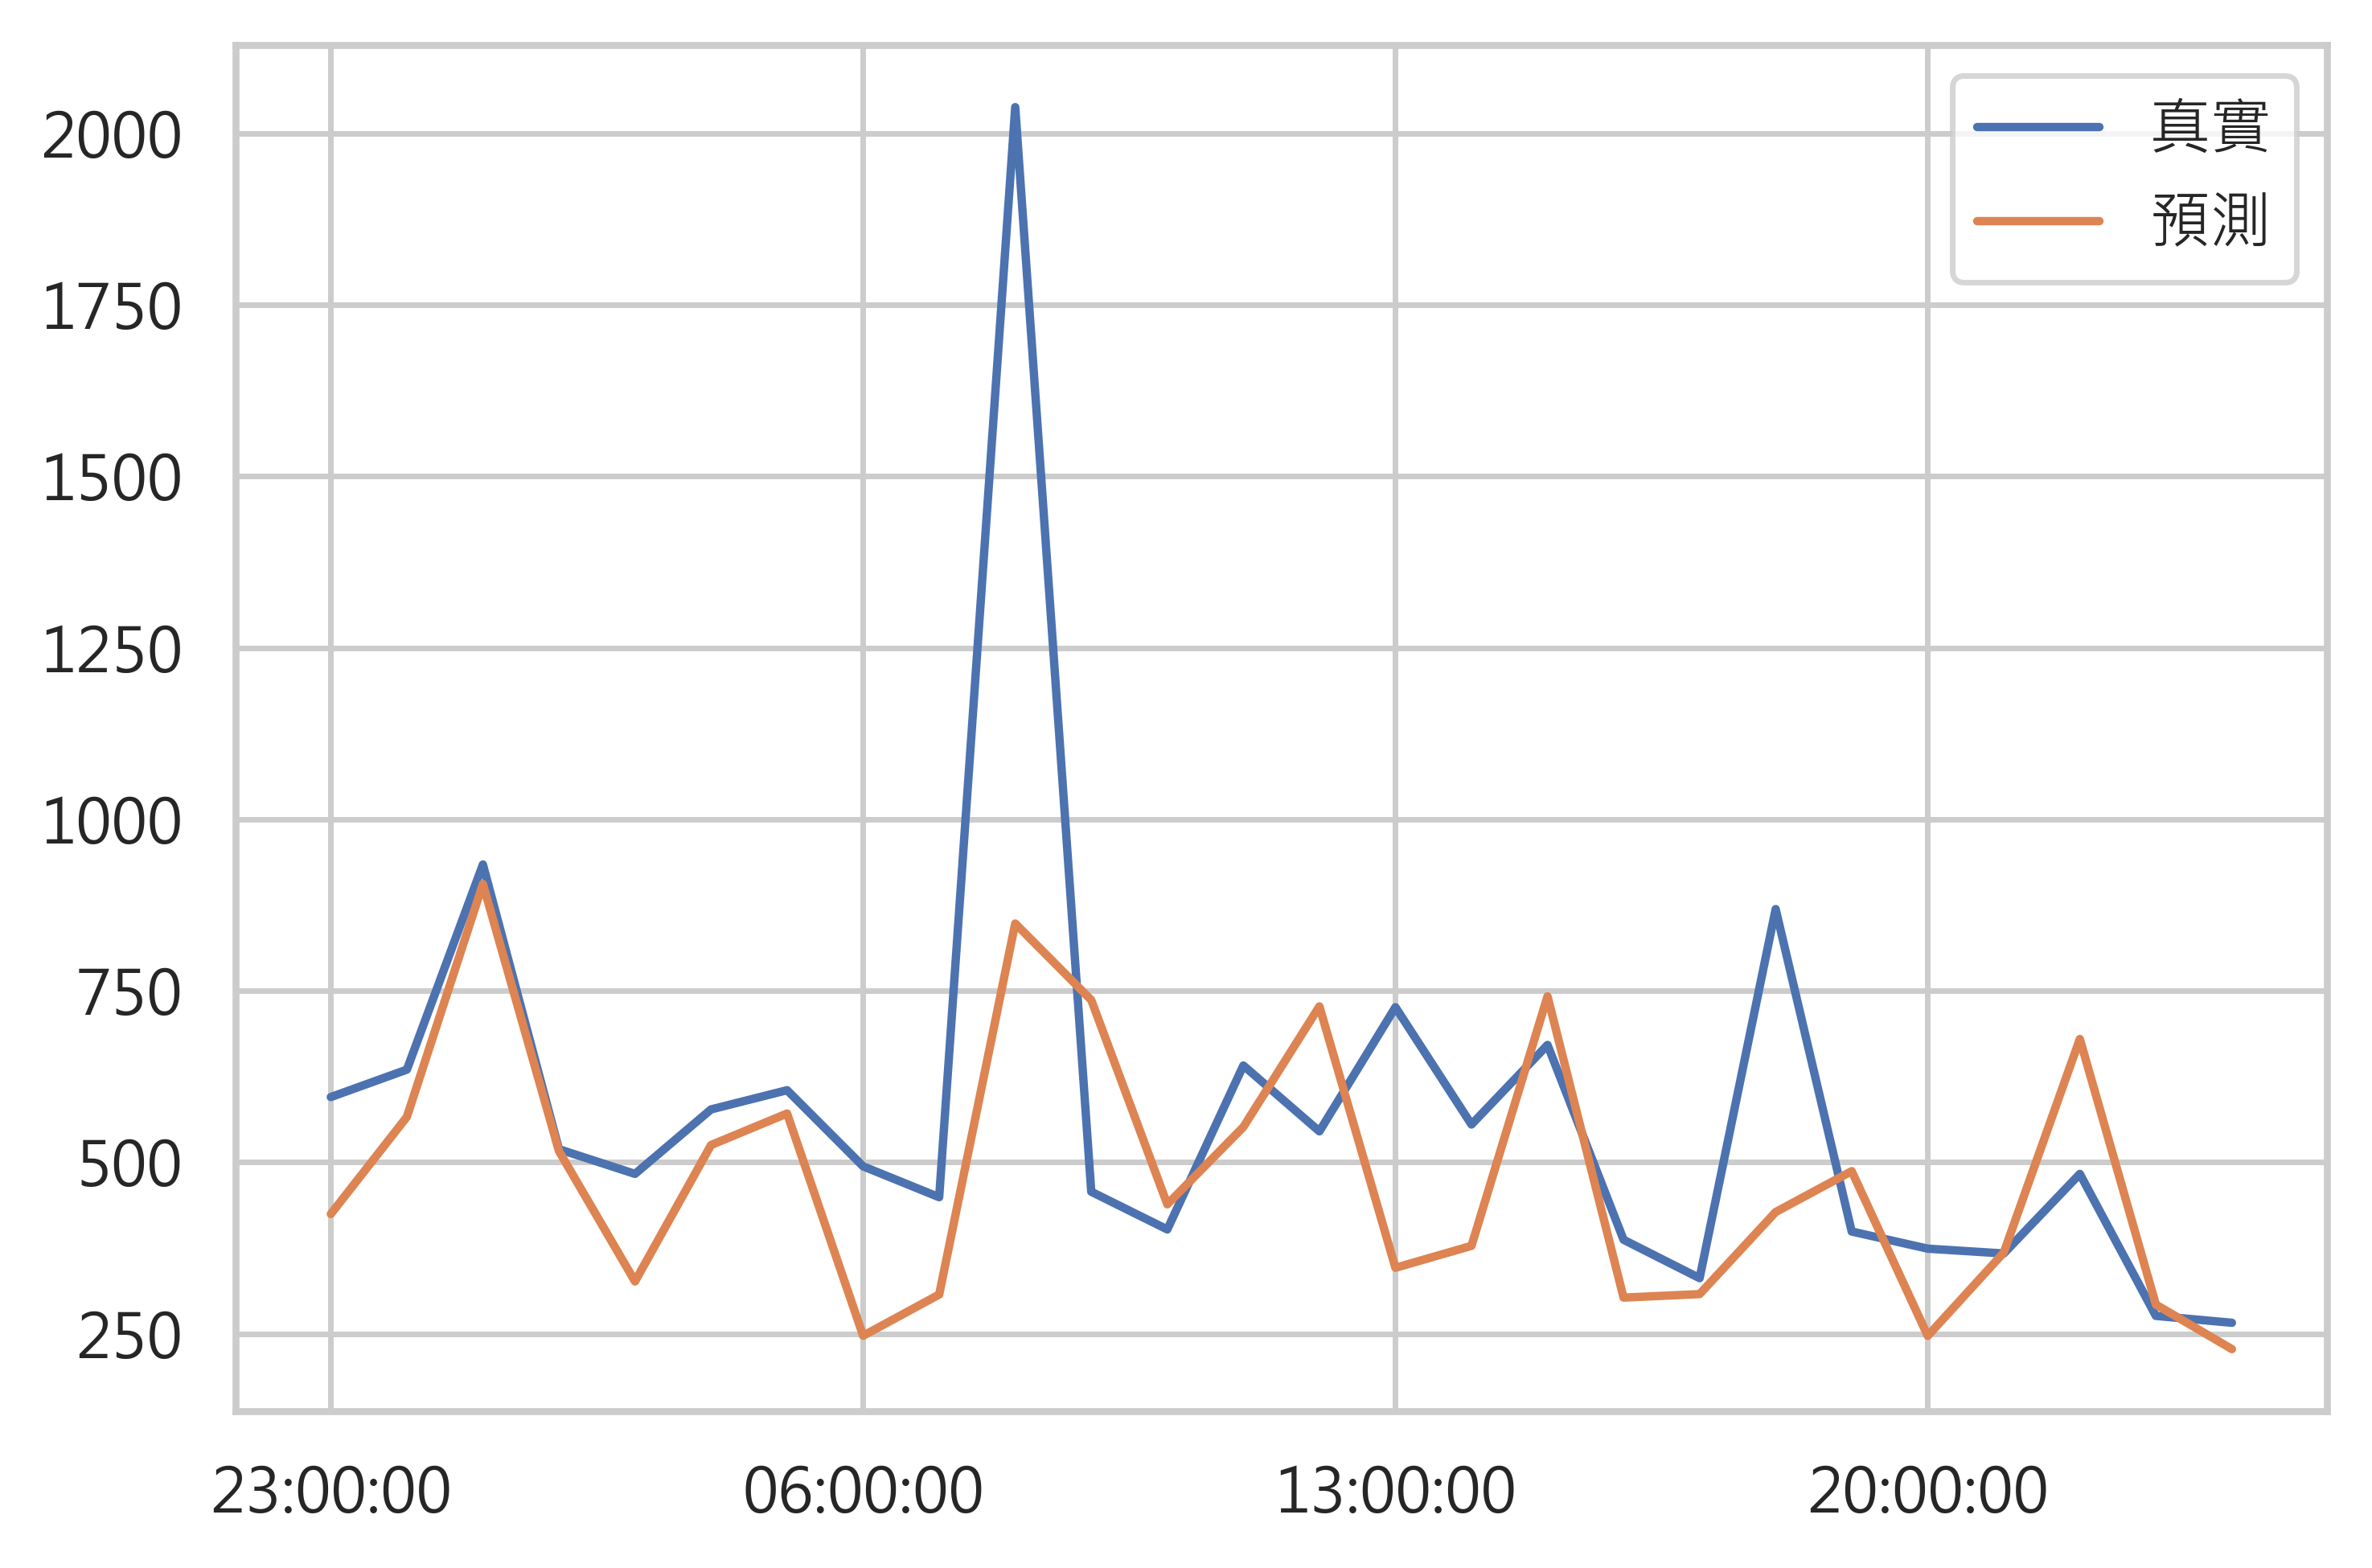

In [176]:
testPredict = model.predict(Xval)
timestamp = np.array(test1[-Xval.shape[0]:]['date'].dt.time)
ind = np.arange(Xval.shape[0])
pnt = 7

plt.subplots(dpi=500)
plt.plot(scaler1.inverse_transform(Yval),label='真實')
plt.plot(scaler1.inverse_transform(testPredict),label='預測')
plt.xticks([i for i in ind if i%pnt==0],[timestamp[i] for i in ind if i%pnt==0],rotation=0)
plt.legend()
plt.tight_layout()

In [177]:
timestamp = test1[-Xval.shape[0]:]['date']
predDF = pd.DataFrame({'date':timestamp, 'prediction': (scaler1.inverse_transform(testPredict)).flatten().tolist()})
predDF['神腦'] = scaler1.inverse_transform(Yval)

# 加上Wide Deep 架構

In [184]:
X_train, Y_train = build_train(dat,ylab=['神腦'], past=4, future=1)
Xtrain, Ytrain, Xval, Yval = train_test_split(X_train, Y_train, rate=0.7)

In [185]:
Xtrain.shape

(60, 4, 34)

In [143]:
#def model_lstm(shape, n_neurons=100,den=1):
#    model_deep = Sequential()
#    model_deep.add(LSTM(n_neurons, input_shape=(shape[1],shape[2]), return_sequences=False))
#    model_deep.add(Dense(10, activation='linear'))
#    model_deep.add(Dropout(0.05))
#    model_deep.add(Dense(5,activation='linear'))
#    model_deep.add(Dropout(0.05))
#    model_deep.add(Dense(1,activation='linear'))
#    model_deep.compile(loss='mean_squared_error', optimizer='adam')
    #model_deep.summary()
#    return(model)

In [186]:
Xtrain_wide = np.array([i[-1] for i in Xtrain])
Xval_wide = np.array([i[-1] for i in Xval])
def two_product(arr):
    tmp = []
    for i in np.arange(len(arr)-1):
        for j in np.arange(i+1, len(arr)):
            tmp.append(arr[i]*arr[j])
    return(np.array(tmp))

#Xtrain_wide = np.array([np.concatenate([i,two_product(i)]) for i in Xtrain_wide])
#Xval_wide = np.array([np.concatenate([i,two_product(i)]) for i in Xval_wide])

In [187]:
model_deep = Sequential()
model_deep.add(LSTM(100, input_shape=(Xtrain.shape[1],Xtrain.shape[2]), return_sequences=False))
model_deep.add(Dense(10, activation='linear'))
model_deep.add(Dropout(0.05))
model_deep.add(Dense(5,activation='linear'))
model_deep.add(Dropout(0.05))
model_deep.add(Dense(1,activation='linear'))
model_deep.compile(loss='mean_squared_error', optimizer='adam')

In [188]:
model_wide = Sequential()
model_wide.add(Dense(10, activation='linear',input_shape=(Xtrain_wide.shape[1],)))
#model_wide.add(Dropout(0.05))
model_wide.add(Dense(5, activation='linear'))
#model_wide.add(Dropout(0.05))
model_wide.add(Dense(1, activation='linear'))
model_wide.compile(loss='mse', optimizer='adam')

In [189]:
merged_model = concatenate([model_deep.output,model_wide.output])
merged_model = Dense(1)(merged_model)

complete_model = Model([model_deep.input] + [model_wide.input], merged_model)
complete_model.compile(loss='mse', optimizer='adam')

In [190]:
# Training
callback = EarlyStopping(monitor="val_loss", patience=20, verbose=1, mode="auto")
complete_model.fit([Xtrain, Xtrain_wide], Ytrain, 
                   validation_data=([Xval, Xval_wide], Yval), 
                   callbacks=[callback], epochs=500, batch_size=10)

Train on 60 samples, validate on 26 samples
Epoch 1/500
60/60 [==============================] - 4s 72ms/step - loss: 0.0343 - val_loss: 0.0382
Epoch 2/500
60/60 [==============================] - 0s 864us/step - loss: 0.0221 - val_loss: 0.0319
Epoch 3/500
60/60 [==============================] - 0s 898us/step - loss: 0.0201 - val_loss: 0.0415
Epoch 4/500
60/60 [==============================] - 0s 947us/step - loss: 0.0174 - val_loss: 0.0314
Epoch 5/500
60/60 [==============================] - 0s 848us/step - loss: 0.0219 - val_loss: 0.0322
Epoch 6/500
60/60 [==============================] - 0s 964us/step - loss: 0.0193 - val_loss: 0.0316
Epoch 7/500
60/60 [==============================] - 0s 964us/step - loss: 0.0212 - val_loss: 0.0319
Epoch 8/500
60/60 [==============================] - 0s 864us/step - loss: 0.0203 - val_loss: 0.0380
Epoch 9/500
60/60 [==============================] - 0s 947us/step - loss: 0.0193 - val_loss: 0.0301
Epoch 10/500
60/60 [============================

60/60 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0257
Epoch 82/500
60/60 [==============================] - 0s 1ms/step - loss: 0.0136 - val_loss: 0.0256
Epoch 83/500
60/60 [==============================] - 0s 1ms/step - loss: 0.0099 - val_loss: 0.0259
Epoch 84/500
60/60 [==============================] - 0s 939us/step - loss: 0.0135 - val_loss: 0.0248
Epoch 85/500
60/60 [==============================] - 0s 898us/step - loss: 0.0114 - val_loss: 0.0286
Epoch 86/500
60/60 [==============================] - 0s 798us/step - loss: 0.0097 - val_loss: 0.0249
Epoch 87/500
60/60 [==============================] - 0s 831us/step - loss: 0.0091 - val_loss: 0.0273
Epoch 88/500
60/60 [==============================] - 0s 831us/step - loss: 0.0110 - val_loss: 0.0249
Epoch 89/500
60/60 [==============================] - 0s 898us/step - loss: 0.0090 - val_loss: 0.0265
Epoch 90/500
60/60 [==============================] - 0s 914us/step - loss: 0.0084 - val_loss: 0.0258

Train Score: 0.08 RMSE
Test Score: 0.16 RMSE


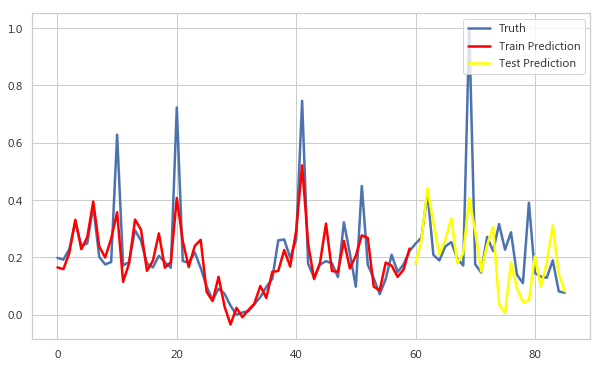

In [191]:
# Evaluation
#conclude(complete_model,[Xtrain, np.array([i[-1] for i in Xtrain])],[Xval, np.array([i[-1] for i in Xval])],Ytrain,Yval, data=test2, scaler=scaler1)
conclude(complete_model,[Xtrain, Xtrain_wide],[Xval, Xval_wide],Ytrain,Yval)

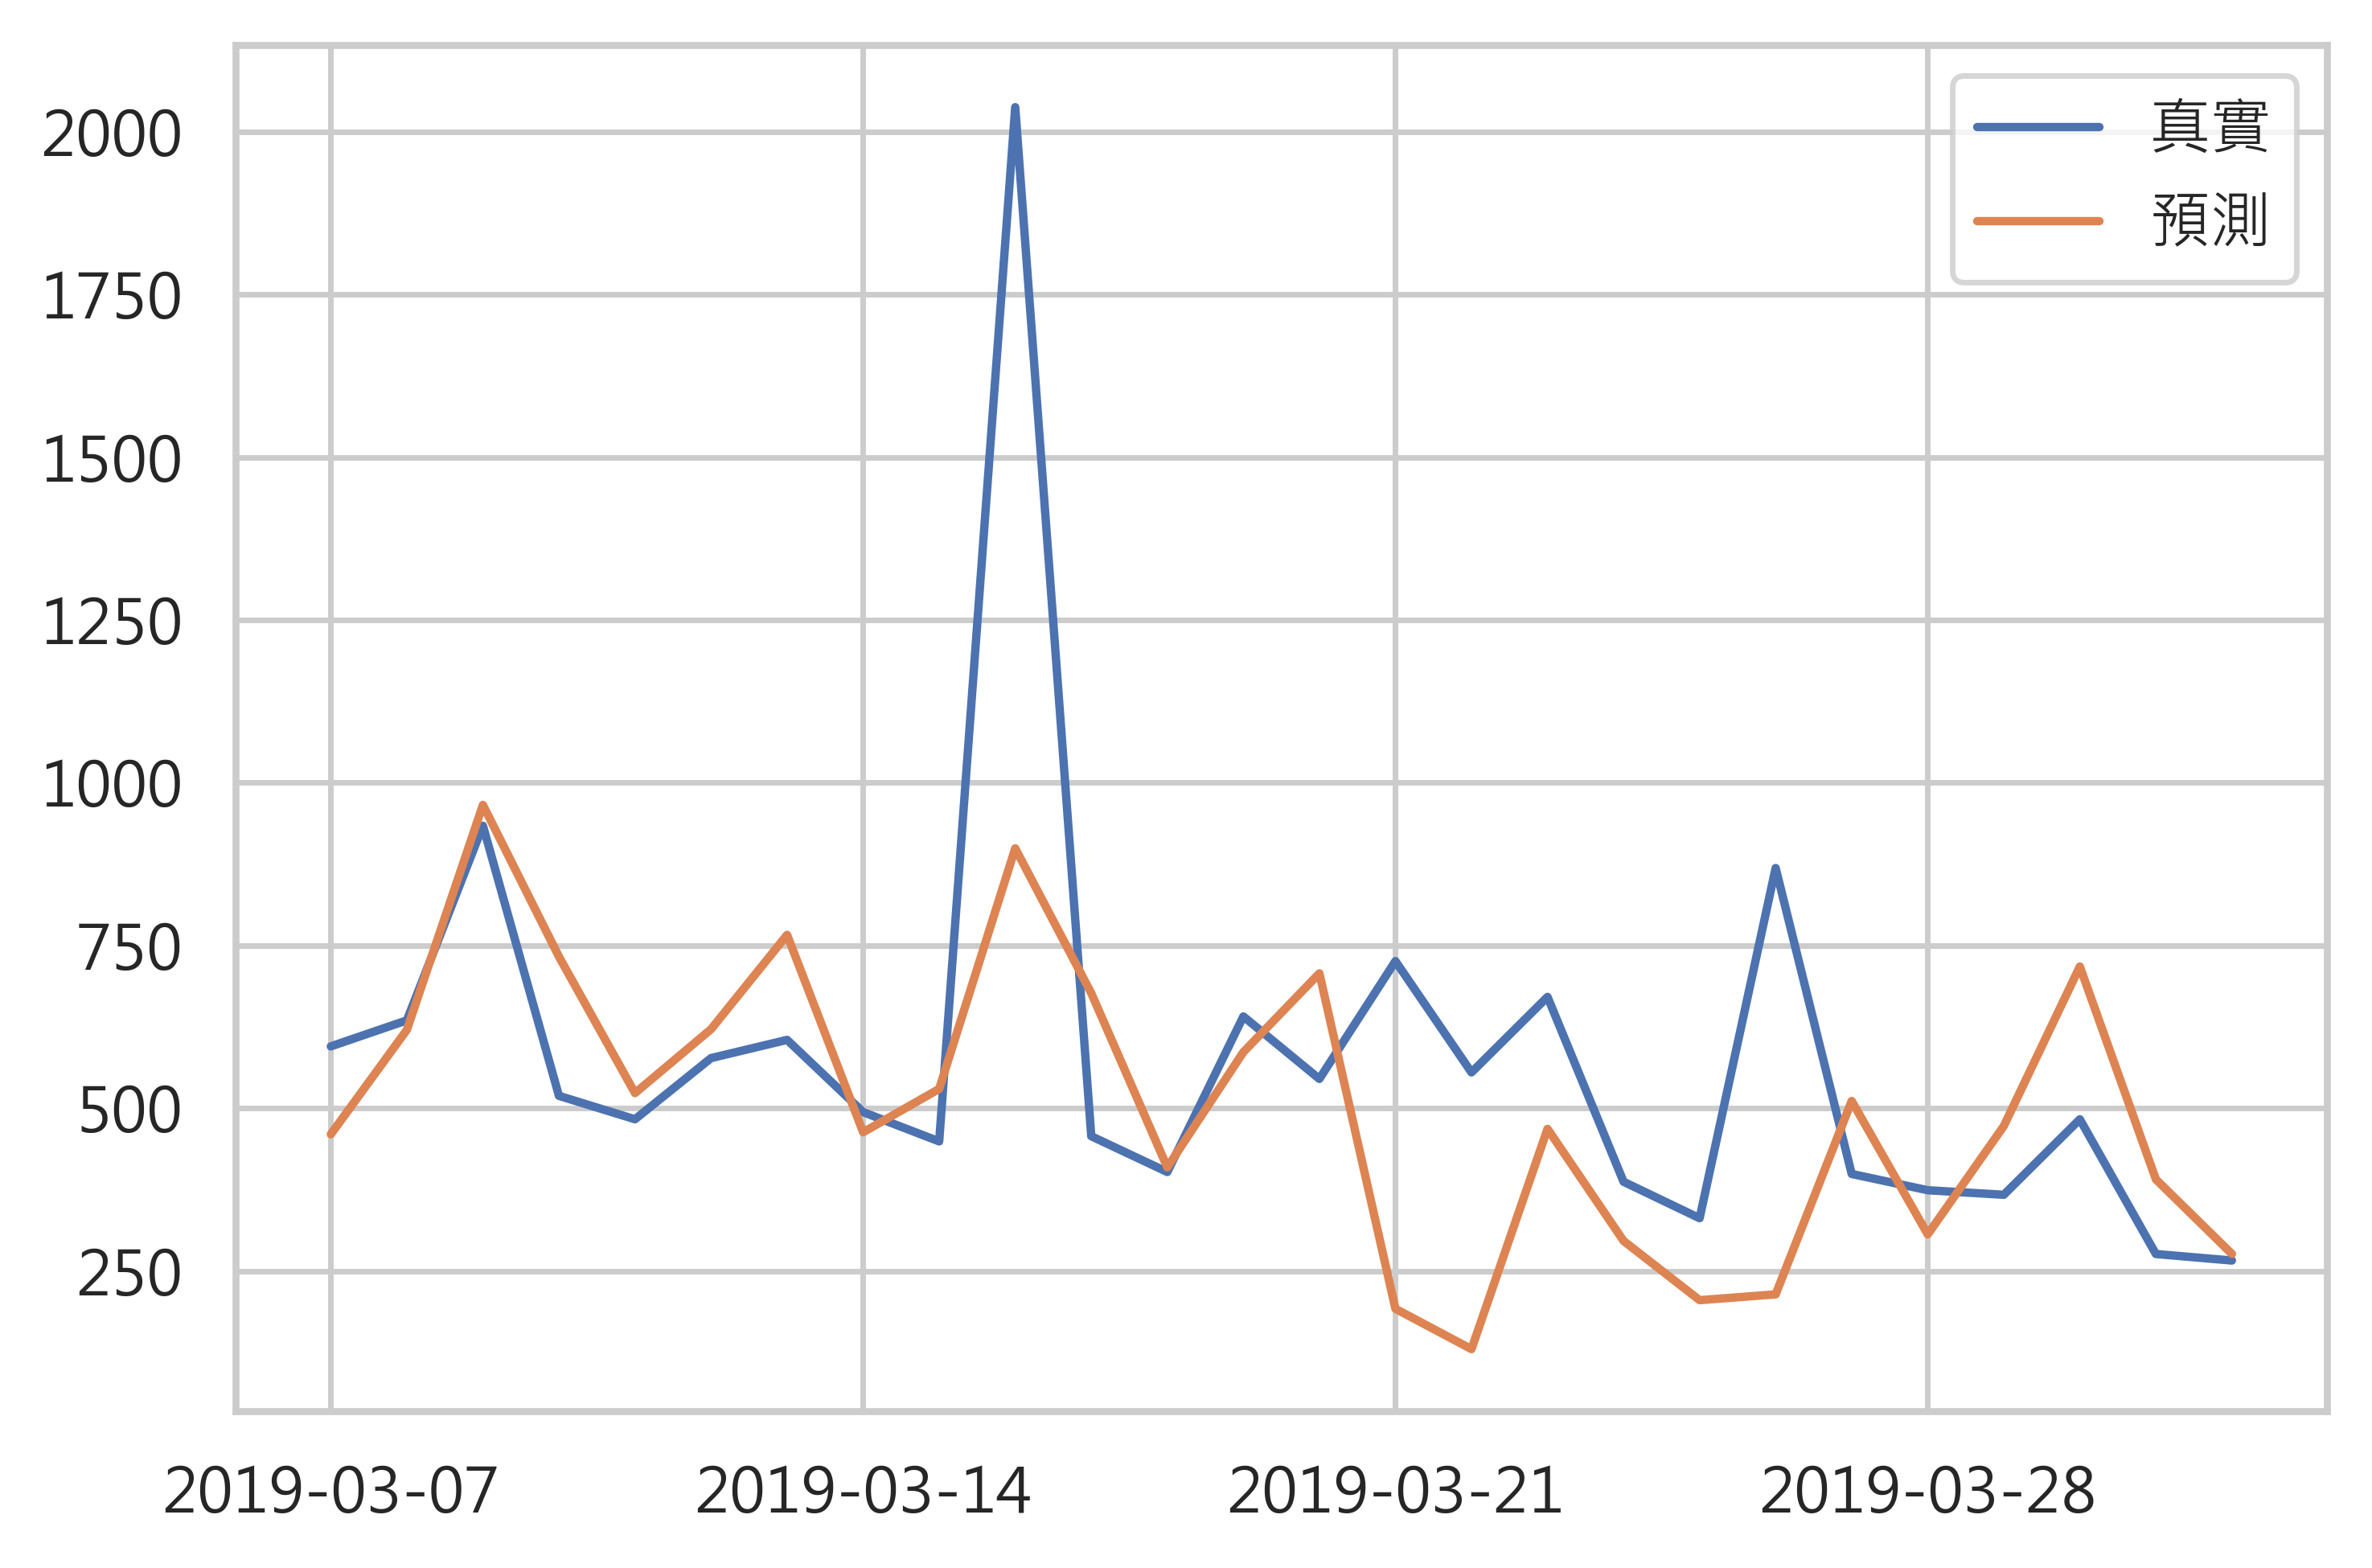

In [192]:
testPredict = complete_model.predict([Xval,Xval_wide])
timestamp = np.array(test2[-Xval.shape[0]:]['date'].dt.date)
ind = np.arange(Xval.shape[0])
pnt = 7

plt.subplots(dpi=500)
plt.plot(scaler1.inverse_transform(Yval),label='真實')
plt.plot(scaler1.inverse_transform(testPredict),label='預測')
plt.xticks([i for i in ind if i%pnt==0],[timestamp[i] for i in ind if i%pnt==0],rotation=0)
plt.legend()
plt.tight_layout()

In [193]:
timestamp = test2[-Xval.shape[0]:]['date']
predDF = pd.DataFrame({'date':timestamp, 'prediction': (scaler1.inverse_transform(testPredict)).flatten().tolist()})
predDF['神腦'] = scaler1.inverse_transform(Yval)

In [194]:
predDF.head(20)

,date,prediction,神腦
65,2019-03-07,459.978577,595.0
66,2019-03-08,620.416931,635.0
67,2019-03-09,965.969177,934.0
68,2019-03-10,732.781433,519.0
69,2019-03-11,523.224182,483.0
70,2019-03-12,621.369751,577.0
71,2019-03-13,766.327515,605.0
72,2019-03-14,463.046021,494.0
73,2019-03-15,529.671143,449.0
74,2019-03-16,899.259338,2038.0
